# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

[2.06106005e-09 4.53978686e-05 9.99954600e-01]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
print(probs)
d = linear_classifer.cross_entropy_loss(probs, 1)
print("d = ", d)

[4.50940412e-05 6.69254912e-03 9.93262357e-01]
d =  5.006760443547122


После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [5]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [7]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [9]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [11]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [4]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.302317
Epoch 1, loss: 2.303185
Epoch 2, loss: 2.302271
Epoch 3, loss: 2.303194
Epoch 4, loss: 2.302338
Epoch 5, loss: 2.301946
Epoch 6, loss: 2.302544
Epoch 7, loss: 2.301348
Epoch 8, loss: 2.301076
Epoch 9, loss: 2.301775


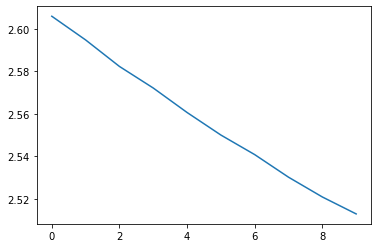

In [5]:
# let's look at the loss history!
plt.plot(loss_history)

In [6]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.113
Epoch 0, loss: 2.303240
Epoch 1, loss: 2.302430
Epoch 2, loss: 2.300641
Epoch 3, loss: 2.302155
Epoch 4, loss: 2.302494
Epoch 5, loss: 2.300200
Epoch 6, loss: 2.300596
Epoch 7, loss: 2.301555
Epoch 8, loss: 2.301820
Epoch 9, loss: 2.301789
Epoch 10, loss: 2.300205
Epoch 11, loss: 2.301226
Epoch 12, loss: 2.300057
Epoch 13, loss: 2.299913
Epoch 14, loss: 2.301913
Epoch 15, loss: 2.301299
Epoch 16, loss: 2.301105
Epoch 17, loss: 2.301654
Epoch 18, loss: 2.300629
Epoch 19, loss: 2.302569
Epoch 20, loss: 2.300418
Epoch 21, loss: 2.302342
Epoch 22, loss: 2.301812
Epoch 23, loss: 2.302024
Epoch 24, loss: 2.302636
Epoch 25, loss: 2.302546
Epoch 26, loss: 2.301827
Epoch 27, loss: 2.302267
Epoch 28, loss: 2.302103
Epoch 29, loss: 2.301126
Epoch 30, loss: 2.302257
Epoch 31, loss: 2.301800
Epoch 32, loss: 2.301003
Epoch 33, loss: 2.301999
Epoch 34, loss: 2.301478
Epoch 35, loss: 2.301324
Epoch 36, loss: 2.302488
Epoch 37, loss: 2.301382
Epoch 38, loss: 2.300878
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [19]:
num_epochs = 200
batch_size = 300

results = {}
best_val = -1
learning_rates = [1e-3, 1e-4, 1e-5, 10 ** np.random.uniform(-6, 1), 5.25E-03]
regularization_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

grid_search = [ (lr, rg) for lr in learning_rates for rg in regularization_strengths]

for lr, rg in grid_search:
    # Create a new Softmax instance
    softmax_model = linear_classifer.LinearSoftmaxClassifier()
    # Train the model with current parameters
    softmax_model.fit(train_X, train_y,batch_size=batch_size, learning_rate=lr, reg=rg, epochs=num_epochs)
    # Predict values for training set
    y_train_pred = softmax_model.predict(train_X)
    # Calculate accuracy
    train_accuracy = multiclass_accuracy(y_train_pred,train_y)
    # Predict values for validation set
    y_val_pred = softmax_model.predict(val_X)
    # Calculate accuracy
    val_accuracy = multiclass_accuracy(y_val_pred, val_y)
    # Save results
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_classifier = softmax_model
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

#print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.302910
Epoch 1, loss: 2.302262
Epoch 2, loss: 2.302231
Epoch 3, loss: 2.301475
Epoch 4, loss: 2.302454
Epoch 5, loss: 2.301449
Epoch 6, loss: 2.302880
Epoch 7, loss: 2.302612
Epoch 8, loss: 2.303635
Epoch 9, loss: 2.302136
Epoch 10, loss: 2.302758
Epoch 11, loss: 2.302651
Epoch 12, loss: 2.303074
Epoch 13, loss: 2.302155
Epoch 14, loss: 2.301867
Epoch 15, loss: 2.301608
Epoch 16, loss: 2.302311
Epoch 17, loss: 2.301678
Epoch 18, loss: 2.302088
Epoch 19, loss: 2.300768
Epoch 20, loss: 2.302106
Epoch 21, loss: 2.301208
Epoch 22, loss: 2.301248
Epoch 23, loss: 2.302740
Epoch 24, loss: 2.302275
Epoch 25, loss: 2.301305
Epoch 26, loss: 2.301006
Epoch 27, loss: 2.301043
Epoch 28, loss: 2.301595
Epoch 29, loss: 2.301170
Epoch 30, loss: 2.302663
Epoch 31, loss: 2.302173
Epoch 32, loss: 2.300358
Epoch 33, loss: 2.300666
Epoch 34, loss: 2.301258
Epoch 35, loss: 2.300991
Epoch 36, loss: 2.301133
Epoch 37, loss: 2.301241
Epoch 38, loss: 2.299848
Epoch 39, loss: 2.302330
Epoch 40, 

Epoch 132, loss: 2.298911
Epoch 133, loss: 2.299317
Epoch 134, loss: 2.298417
Epoch 135, loss: 2.300275
Epoch 136, loss: 2.297515
Epoch 137, loss: 2.300116
Epoch 138, loss: 2.296555
Epoch 139, loss: 2.299465
Epoch 140, loss: 2.298293
Epoch 141, loss: 2.297275
Epoch 142, loss: 2.295382
Epoch 143, loss: 2.297736
Epoch 144, loss: 2.298156
Epoch 145, loss: 2.295168
Epoch 146, loss: 2.298762
Epoch 147, loss: 2.300393
Epoch 148, loss: 2.297504
Epoch 149, loss: 2.298302
Epoch 150, loss: 2.296923
Epoch 151, loss: 2.298362
Epoch 152, loss: 2.298319
Epoch 153, loss: 2.295949
Epoch 154, loss: 2.297847
Epoch 155, loss: 2.298746
Epoch 156, loss: 2.296151
Epoch 157, loss: 2.294977
Epoch 158, loss: 2.296167
Epoch 159, loss: 2.299008
Epoch 160, loss: 2.296435
Epoch 161, loss: 2.299412
Epoch 162, loss: 2.294999
Epoch 163, loss: 2.296405
Epoch 164, loss: 2.297677
Epoch 165, loss: 2.297589
Epoch 166, loss: 2.295697
Epoch 167, loss: 2.296061
Epoch 168, loss: 2.297162
Epoch 169, loss: 2.295784
Epoch 170, l

Epoch 65, loss: 2.302423
Epoch 66, loss: 2.302085
Epoch 67, loss: 2.302803
Epoch 68, loss: 2.302787
Epoch 69, loss: 2.302288
Epoch 70, loss: 2.302800
Epoch 71, loss: 2.302908
Epoch 72, loss: 2.301976
Epoch 73, loss: 2.302064
Epoch 74, loss: 2.302415
Epoch 75, loss: 2.302766
Epoch 76, loss: 2.302109
Epoch 77, loss: 2.302201
Epoch 78, loss: 2.302845
Epoch 79, loss: 2.302262
Epoch 80, loss: 2.301830
Epoch 81, loss: 2.302268
Epoch 82, loss: 2.302302
Epoch 83, loss: 2.302187
Epoch 84, loss: 2.301557
Epoch 85, loss: 2.301854
Epoch 86, loss: 2.301722
Epoch 87, loss: 2.302010
Epoch 88, loss: 2.301745
Epoch 89, loss: 2.302077
Epoch 90, loss: 2.303090
Epoch 91, loss: 2.301870
Epoch 92, loss: 2.301735
Epoch 93, loss: 2.302428
Epoch 94, loss: 2.302341
Epoch 95, loss: 2.303045
Epoch 96, loss: 2.302455
Epoch 97, loss: 2.303327
Epoch 98, loss: 2.301866
Epoch 99, loss: 2.301442
Epoch 100, loss: 2.302014
Epoch 101, loss: 2.301505
Epoch 102, loss: 2.301667
Epoch 103, loss: 2.302200
Epoch 104, loss: 2.30

Epoch 187, loss: 2.301346
Epoch 188, loss: 2.301568
Epoch 189, loss: 2.301618
Epoch 190, loss: 2.302786
Epoch 191, loss: 2.301840
Epoch 192, loss: 2.301275
Epoch 193, loss: 2.302528
Epoch 194, loss: 2.302303
Epoch 195, loss: 2.302008
Epoch 196, loss: 2.302221
Epoch 197, loss: 2.302671
Epoch 198, loss: 2.302125
Epoch 199, loss: 2.302670
Epoch 0, loss: 2.302274
Epoch 1, loss: 2.302457
Epoch 2, loss: 2.302246
Epoch 3, loss: 2.302089
Epoch 4, loss: 2.301942
Epoch 5, loss: 2.302305
Epoch 6, loss: 2.302315
Epoch 7, loss: 2.302252
Epoch 8, loss: 2.302130
Epoch 9, loss: 2.302826
Epoch 10, loss: 2.302583
Epoch 11, loss: 2.301724
Epoch 12, loss: 2.301846
Epoch 13, loss: 2.302776
Epoch 14, loss: 2.302367
Epoch 15, loss: 2.301747
Epoch 16, loss: 2.302182
Epoch 17, loss: 2.303160
Epoch 18, loss: 2.302410
Epoch 19, loss: 2.303639
Epoch 20, loss: 2.302148
Epoch 21, loss: 2.302510
Epoch 22, loss: 2.302408
Epoch 23, loss: 2.302636
Epoch 24, loss: 2.301091
Epoch 25, loss: 2.302998
Epoch 26, loss: 2.3019

Epoch 121, loss: 2.301938
Epoch 122, loss: 2.302720
Epoch 123, loss: 2.302904
Epoch 124, loss: 2.303232
Epoch 125, loss: 2.303229
Epoch 126, loss: 2.301853
Epoch 127, loss: 2.302252
Epoch 128, loss: 2.302009
Epoch 129, loss: 2.302979
Epoch 130, loss: 2.302570
Epoch 131, loss: 2.302309
Epoch 132, loss: 2.303468
Epoch 133, loss: 2.302165
Epoch 134, loss: 2.302888
Epoch 135, loss: 2.303577
Epoch 136, loss: 2.302612
Epoch 137, loss: 2.302349
Epoch 138, loss: 2.302683
Epoch 139, loss: 2.301655
Epoch 140, loss: 2.302692
Epoch 141, loss: 2.303351
Epoch 142, loss: 2.302675
Epoch 143, loss: 2.302933
Epoch 144, loss: 2.302223
Epoch 145, loss: 2.302559
Epoch 146, loss: 2.302394
Epoch 147, loss: 2.302297
Epoch 148, loss: 2.302362
Epoch 149, loss: 2.302283
Epoch 150, loss: 2.303053
Epoch 151, loss: 2.303514
Epoch 152, loss: 2.302235
Epoch 153, loss: 2.302753
Epoch 154, loss: 2.303692
Epoch 155, loss: 2.302688
Epoch 156, loss: 2.304082
Epoch 157, loss: 2.303125
Epoch 158, loss: 2.302525
Epoch 159, l

Epoch 63, loss: 2.303377
Epoch 64, loss: 2.302216
Epoch 65, loss: 2.303709
Epoch 66, loss: 2.302404
Epoch 67, loss: 2.303248
Epoch 68, loss: 2.303911
Epoch 69, loss: 2.302725
Epoch 70, loss: 2.303569
Epoch 71, loss: 2.303526
Epoch 72, loss: 2.302528
Epoch 73, loss: 2.302966
Epoch 74, loss: 2.301914
Epoch 75, loss: 2.303364
Epoch 76, loss: 2.302070
Epoch 77, loss: 2.302771
Epoch 78, loss: 2.303049
Epoch 79, loss: 2.303083
Epoch 80, loss: 2.303256
Epoch 81, loss: 2.303390
Epoch 82, loss: 2.302981
Epoch 83, loss: 2.303302
Epoch 84, loss: 2.303411
Epoch 85, loss: 2.301705
Epoch 86, loss: 2.303069
Epoch 87, loss: 2.303759
Epoch 88, loss: 2.303347
Epoch 89, loss: 2.302698
Epoch 90, loss: 2.302785
Epoch 91, loss: 2.301969
Epoch 92, loss: 2.304149
Epoch 93, loss: 2.302699
Epoch 94, loss: 2.302422
Epoch 95, loss: 2.303526
Epoch 96, loss: 2.302992
Epoch 97, loss: 2.303514
Epoch 98, loss: 2.301987
Epoch 99, loss: 2.302922
Epoch 100, loss: 2.301646
Epoch 101, loss: 2.303333
Epoch 102, loss: 2.3020

Epoch 194, loss: 2.183278
Epoch 195, loss: 2.163465
Epoch 196, loss: 2.177384
Epoch 197, loss: 2.180790
Epoch 198, loss: 2.196982
Epoch 199, loss: 2.175645
Epoch 0, loss: 2.302753
Epoch 1, loss: 2.305904
Epoch 2, loss: 2.293694
Epoch 3, loss: 2.289111
Epoch 4, loss: 2.306520
Epoch 5, loss: 2.297266
Epoch 6, loss: 2.285783
Epoch 7, loss: 2.291607
Epoch 8, loss: 2.302968
Epoch 9, loss: 2.292214
Epoch 10, loss: 2.289902
Epoch 11, loss: 2.280526
Epoch 12, loss: 2.289543
Epoch 13, loss: 2.283447
Epoch 14, loss: 2.288812
Epoch 15, loss: 2.280403
Epoch 16, loss: 2.283279
Epoch 17, loss: 2.282033
Epoch 18, loss: 2.272413
Epoch 19, loss: 2.267383
Epoch 20, loss: 2.284326
Epoch 21, loss: 2.262904
Epoch 22, loss: 2.277935
Epoch 23, loss: 2.270217
Epoch 24, loss: 2.277593
Epoch 25, loss: 2.267221
Epoch 26, loss: 2.261771
Epoch 27, loss: 2.266340
Epoch 28, loss: 2.258409
Epoch 29, loss: 2.284440
Epoch 30, loss: 2.261700
Epoch 31, loss: 2.284970
Epoch 32, loss: 2.255402
Epoch 33, loss: 2.267280
Epoc

Epoch 121, loss: 2.184154
Epoch 122, loss: 2.197958
Epoch 123, loss: 2.212431
Epoch 124, loss: 2.172549
Epoch 125, loss: 2.211260
Epoch 126, loss: 2.179814
Epoch 127, loss: 2.178342
Epoch 128, loss: 2.223336
Epoch 129, loss: 2.180245
Epoch 130, loss: 2.191674
Epoch 131, loss: 2.184475
Epoch 132, loss: 2.184526
Epoch 133, loss: 2.195370
Epoch 134, loss: 2.170156
Epoch 135, loss: 2.188318
Epoch 136, loss: 2.181478
Epoch 137, loss: 2.180001
Epoch 138, loss: 2.188483
Epoch 139, loss: 2.194133
Epoch 140, loss: 2.190104
Epoch 141, loss: 2.213876
Epoch 142, loss: 2.221194
Epoch 143, loss: 2.158048
Epoch 144, loss: 2.181009
Epoch 145, loss: 2.191424
Epoch 146, loss: 2.175923
Epoch 147, loss: 2.199249
Epoch 148, loss: 2.186298
Epoch 149, loss: 2.241982
Epoch 150, loss: 2.188559
Epoch 151, loss: 2.186122
Epoch 152, loss: 2.175343
Epoch 153, loss: 2.186644
Epoch 154, loss: 2.142775
Epoch 155, loss: 2.178374
Epoch 156, loss: 2.204797
Epoch 157, loss: 2.181625
Epoch 158, loss: 2.173283
Epoch 159, l

Epoch 48, loss: 2.295912
Epoch 49, loss: 2.296942
Epoch 50, loss: 2.296067
Epoch 51, loss: 2.291137
Epoch 52, loss: 2.293987
Epoch 53, loss: 2.294188
Epoch 54, loss: 2.296392
Epoch 55, loss: 2.292417
Epoch 56, loss: 2.293059
Epoch 57, loss: 2.290053
Epoch 58, loss: 2.295289
Epoch 59, loss: 2.291857
Epoch 60, loss: 2.299815
Epoch 61, loss: 2.295452
Epoch 62, loss: 2.290345
Epoch 63, loss: 2.294317
Epoch 64, loss: 2.292697
Epoch 65, loss: 2.290655
Epoch 66, loss: 2.294681
Epoch 67, loss: 2.293144
Epoch 68, loss: 2.293817
Epoch 69, loss: 2.292059
Epoch 70, loss: 2.291816
Epoch 71, loss: 2.292749
Epoch 72, loss: 2.295168
Epoch 73, loss: 2.294596
Epoch 74, loss: 2.294187
Epoch 75, loss: 2.293624
Epoch 76, loss: 2.285492
Epoch 77, loss: 2.287599
Epoch 78, loss: 2.292217
Epoch 79, loss: 2.289175
Epoch 80, loss: 2.287697
Epoch 81, loss: 2.286720
Epoch 82, loss: 2.294197
Epoch 83, loss: 2.289815
Epoch 84, loss: 2.289348
Epoch 85, loss: 2.284957
Epoch 86, loss: 2.288867
Epoch 87, loss: 2.291891


Epoch 169, loss: 2.272667
Epoch 170, loss: 2.278509
Epoch 171, loss: 2.277616
Epoch 172, loss: 2.277254
Epoch 173, loss: 2.278971
Epoch 174, loss: 2.277699
Epoch 175, loss: 2.280970
Epoch 176, loss: 2.287619
Epoch 177, loss: 2.279646
Epoch 178, loss: 2.275322
Epoch 179, loss: 2.281749
Epoch 180, loss: 2.270249
Epoch 181, loss: 2.276641
Epoch 182, loss: 2.270393
Epoch 183, loss: 2.280985
Epoch 184, loss: 2.280417
Epoch 185, loss: 2.273978
Epoch 186, loss: 2.278810
Epoch 187, loss: 2.280470
Epoch 188, loss: 2.274053
Epoch 189, loss: 2.283462
Epoch 190, loss: 2.281732
Epoch 191, loss: 2.283446
Epoch 192, loss: 2.274455
Epoch 193, loss: 2.279599
Epoch 194, loss: 2.272185
Epoch 195, loss: 2.277196
Epoch 196, loss: 2.271799
Epoch 197, loss: 2.280457
Epoch 198, loss: 2.278982
Epoch 199, loss: 2.279783
lr 1.000000e-05 reg 1.000000e-06 train accuracy: 0.108333 val accuracy: 0.097000
lr 1.000000e-05 reg 1.000000e-05 train accuracy: 0.087444 val accuracy: 0.090000
lr 1.000000e-05 reg 1.000000e-04

# Какой же точности мы добились на тестовых данных?

In [20]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.190000
